# Protein-mRNA Dataset Processor

This notebook processes the protein-mRNA sequence dataset and organizes it for training conditional GFlowNets with protein sequence conditioning.

## Objectives:
1. Load and clean the protein-mRNA dataset
2. Convert DNA sequences to mRNA sequences
3. Organize sequences by length (short to long)
4. Create training-ready datasets for conditional GFlowNet training
5. Analyze dataset statistics and diversity


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import os
from typing import List, Dict, Tuple
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [3]:
# Utility Functions
def dna_to_mrna(dna_sequence: str) -> str:
    """Convert DNA sequence to mRNA by replacing T with U."""
    return dna_sequence.upper().replace('T', 'U')

def clean_sequence(sequence: str) -> str:
    """Clean sequence by removing spaces and invalid characters."""
    # Remove spaces and convert to uppercase
    cleaned = sequence.replace(' ', '').upper()
    # Remove any non-standard characters (keep only A, T, U, G, C)
    cleaned = re.sub(r'[^ATUGC]', '', cleaned)
    return cleaned

def validate_protein_sequence(protein_seq: str) -> bool:
    """Validate protein sequence contains only valid amino acids."""
    valid_aa = set('ACDEFGHIKLMNPQRSTVWY*')
    return all(aa in valid_aa for aa in protein_seq)

def validate_mrna_sequence(mrna_seq: str) -> bool:
    """Validate mRNA sequence contains only valid nucleotides."""
    valid_nuc = set('AUCG')
    return all(nuc in valid_nuc for nuc in mrna_seq)

def get_sequence_length_category(length: int) -> str:
    """Categorize sequence by length."""
    if length < 100:
        return "Very Short"
    elif length < 300:
        return "Short"
    elif length < 600:
        return "Medium"
    elif length < 1000:
        return "Long"
    else:
        return "Very Long"

In [4]:
print("Loading dataset...")
df = pd.read_csv('Protein_mRNA_sequence_dataset.csv')

print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print("\nFirst few rows:")
print(df.head())

print("\nDataset info:")
print(df.info())

print("\nBasic statistics:")
print(df.describe())


Loading dataset...
Dataset shape: (3804, 3)
Columns: ['protein_sequence', 'coding_sequence', 'info']

First few rows:
                                    protein_sequence  \
0  MCSLGLFPPPPPRGQVTLYEHNNELVTGSSYESPPPDFRGQWINLP...   
1  MAAGVPCALVTSCSSVFSGDQLVQHILGTEDLIVEVTSNDAVRFYP...   
2  MESESESGAAADTPPLETLSFHGDEEIIEVVELDPGPPDPDDLAQE...   
3  MAAVQMDPELAKRLFFEGATVVILNMPKGTEFGIDYNSWEVGPKFR...   
4  MDSTLTASEIRQRFIDFFKRNEHTYVHSSATIPLDDPTLLFANAGM...   

                                     coding_sequence  \
0  ATG TGC TCT CTG GGG TTG TTC CCT CCT CCA CCG CC...   
1  ATG GCT GCT GGC GTA CCC TGT GCG TTA GTC ACC AG...   
2  ATG GAG TCC GAA TCG GAA AGC GGG GCT GCT GCT GA...   
3  ATG GCT GCC GTG CAG ATG GAT CCT GAG CTA GCC AA...   
4  ATG GAC TCT ACT CTA ACA GCA AGT GAA ATC CGG CA...   

                                                info  
0  NM_015665 Homo sapiens aladin WD repeat nucleo...  
1  NM_024666 Homo sapiens alpha and gamma adaptin...  
2  NM_001087 Homo sapiens angio associated 

In [5]:
# Data Cleaning and Processing
print("Processing and cleaning data...")

# Create a copy for processing
processed_df = df.copy()

# Clean protein sequences
processed_df['protein_sequence_clean'] = processed_df['protein_sequence'].apply(clean_sequence)

# Clean and convert DNA to mRNA
processed_df['coding_sequence_clean'] = processed_df['coding_sequence'].apply(clean_sequence)
processed_df['mrna_sequence'] = processed_df['coding_sequence_clean'].apply(dna_to_mrna)

# Calculate sequence lengths
processed_df['protein_length'] = processed_df['protein_sequence_clean'].str.len()
processed_df['mrna_length'] = processed_df['mrna_sequence'].str.len()

# Add length categories
processed_df['protein_length_category'] = processed_df['protein_length'].apply(get_sequence_length_category)
processed_df['mrna_length_category'] = processed_df['mrna_length'].apply(get_sequence_length_category)

# Validate sequences
processed_df['valid_protein'] = processed_df['protein_sequence_clean'].apply(validate_protein_sequence)
processed_df['valid_mrna'] = processed_df['mrna_sequence'].apply(validate_mrna_sequence)

print(f"Processed dataset shape: {processed_df.shape}")
print(f"Valid protein sequences: {processed_df['valid_protein'].sum()}/{len(processed_df)}")
print(f"Valid mRNA sequences: {processed_df['valid_mrna'].sum()}/{len(processed_df)}")

# Filter out invalid sequences
valid_df = processed_df[processed_df['valid_protein'] & processed_df['valid_mrna']].copy()
print(f"Valid sequences after filtering: {len(valid_df)}")

print("\nLength statistics:")
print(f"Protein length - Min: {valid_df['protein_length'].min()}, Max: {valid_df['protein_length'].max()}, Mean: {valid_df['protein_length'].mean():.1f}")
print(f"mRNA length - Min: {valid_df['mrna_length'].min()}, Max: {valid_df['mrna_length'].max()}, Mean: {valid_df['mrna_length'].mean():.1f}")


Processing and cleaning data...
Processed dataset shape: (3804, 12)
Valid protein sequences: 3804/3804
Valid mRNA sequences: 3804/3804
Valid sequences after filtering: 3804

Length statistics:
Protein length - Min: 4, Max: 942, Mean: 99.9
mRNA length - Min: 96, Max: 13125, Mean: 1462.8


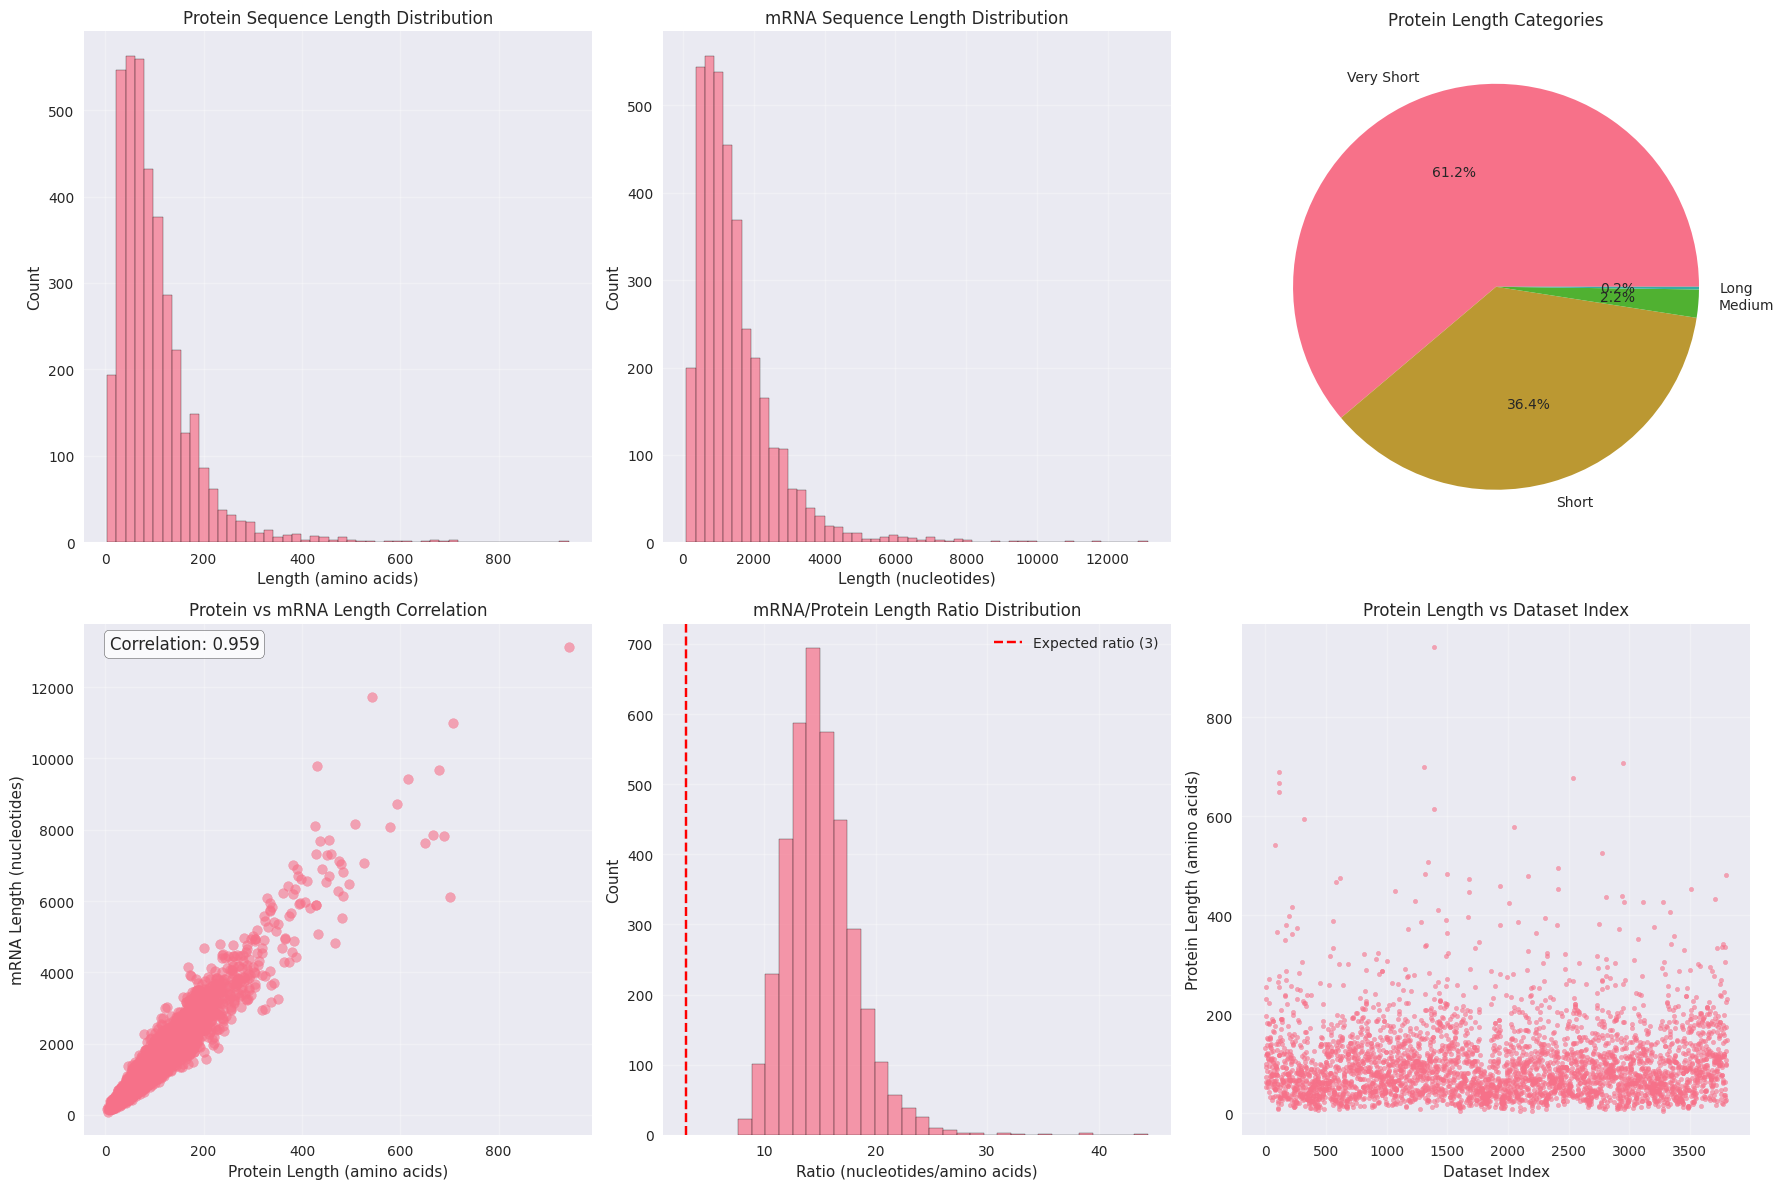

Dataset Summary Statistics:
Total valid sequences: 3804
Protein length range: 4 - 942
mRNA length range: 96 - 13125
Average length ratio: 15.07 ± 3.16
Expected ratio (3:1): 3.0

Length category distribution:
protein_length_category
Long             8
Medium          85
Short         1384
Very Short    2327
Name: count, dtype: int64


In [6]:
# Dataset Analysis and Visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Protein length distribution
axes[0, 0].hist(valid_df['protein_length'], bins=50, alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Protein Sequence Length Distribution')
axes[0, 0].set_xlabel('Length (amino acids)')
axes[0, 0].set_ylabel('Count')
axes[0, 0].grid(True, alpha=0.3)

# 2. mRNA length distribution
axes[0, 1].hist(valid_df['mrna_length'], bins=50, alpha=0.7, edgecolor='black')
axes[0, 1].set_title('mRNA Sequence Length Distribution')
axes[0, 1].set_xlabel('Length (nucleotides)')
axes[0, 1].set_ylabel('Count')
axes[0, 1].grid(True, alpha=0.3)

# 3. Length category distribution
protein_cat_counts = valid_df['protein_length_category'].value_counts()
axes[0, 2].pie(protein_cat_counts.values, labels=protein_cat_counts.index, autopct='%1.1f%%')
axes[0, 2].set_title('Protein Length Categories')

# 4. Length correlation
axes[1, 0].scatter(valid_df['protein_length'], valid_df['mrna_length'], alpha=0.6)
axes[1, 0].set_title('Protein vs mRNA Length Correlation')
axes[1, 0].set_xlabel('Protein Length (amino acids)')
axes[1, 0].set_ylabel('mRNA Length (nucleotides)')
axes[1, 0].grid(True, alpha=0.3)

# Add correlation coefficient
correlation = valid_df['protein_length'].corr(valid_df['mrna_length'])
axes[1, 0].text(0.05, 0.95, f'Correlation: {correlation:.3f}',
                transform=axes[1, 0].transAxes, fontsize=12,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 5. Length ratio distribution
valid_df['length_ratio'] = valid_df['mrna_length'] / valid_df['protein_length']
axes[1, 1].hist(valid_df['length_ratio'], bins=30, alpha=0.7, edgecolor='black')
axes[1, 1].set_title('mRNA/Protein Length Ratio Distribution')
axes[1, 1].set_xlabel('Ratio (nucleotides/amino acids)')
axes[1, 1].set_ylabel('Count')
axes[1, 1].axvline(3, color='red', linestyle='--', label='Expected ratio (3)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# 6. Sequence length over index (to see if there's ordering)
axes[1, 2].scatter(range(len(valid_df)), valid_df['protein_length'], alpha=0.6, s=10)
axes[1, 2].set_title('Protein Length vs Dataset Index')
axes[1, 2].set_xlabel('Dataset Index')
axes[1, 2].set_ylabel('Protein Length (amino acids)')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("Dataset Summary Statistics:")
print("=" * 50)
print(f"Total valid sequences: {len(valid_df)}")
print(f"Protein length range: {valid_df['protein_length'].min()} - {valid_df['protein_length'].max()}")
print(f"mRNA length range: {valid_df['mrna_length'].min()} - {valid_df['mrna_length'].max()}")
print(f"Average length ratio: {valid_df['length_ratio'].mean():.2f} ± {valid_df['length_ratio'].std():.2f}")
print(f"Expected ratio (3:1): {3.0}")

print("\nLength category distribution:")
print(valid_df['protein_length_category'].value_counts().sort_index())


In [7]:
# Organize Dataset by Length (Short to Long)
print("Organizing dataset by protein sequence length...")

# Sort by protein length (short to long)
sorted_df = valid_df.sort_values('protein_length').reset_index(drop=True)

print(f"Dataset sorted by protein length (short to long)")
print(f"Shortest protein: {sorted_df.iloc[0]['protein_length']} amino acids")
print(f"Longest protein: {sorted_df.iloc[-1]['protein_length']} amino acids")

# Create length-based subsets for different training scenarios
def create_length_subsets(df, min_length=None, max_length=None):
    """Create subsets based on protein length."""
    if min_length is not None:
        df = df[df['protein_length'] >= min_length]
    if max_length is not None:
        df = df[df['protein_length'] <= max_length]
    return df.reset_index(drop=True)

# Define length ranges for different training scenarios
length_subsets = {
    'very_short': create_length_subsets(sorted_df, max_length=100),
    'short': create_length_subsets(sorted_df, min_length=50, max_length=200),
    'medium': create_length_subsets(sorted_df, min_length=150, max_length=400),
    'long': create_length_subsets(sorted_df, min_length=300, max_length=600),
    'very_long': create_length_subsets(sorted_df, min_length=500),
    'all': sorted_df
}

print("\nLength subset statistics:")
for name, subset in length_subsets.items():
    if len(subset) > 0:
        print(f"{name:12}: {len(subset):4d} sequences, "
              f"length range: {subset['protein_length'].min():3d}-{subset['protein_length'].max():3d}")

# Create progressive training sets (cumulative)
progressive_sets = {}
cumulative_lengths = [50, 100, 200, 300, 500, 1000]

for max_len in cumulative_lengths:
    subset = create_length_subsets(sorted_df, max_length=max_len)
    if len(subset) > 0:
        progressive_sets[f'up_to_{max_len}'] = subset

print("\nProgressive training sets:")
for name, subset in progressive_sets.items():
    print(f"{name:12}: {len(subset):4d} sequences, "
          f"max length: {subset['protein_length'].max():3d}")

# Save the sorted dataset
sorted_df.to_csv('protein_mrna_dataset_sorted.csv', index=False)
print(f"\nSorted dataset saved to 'protein_mrna_dataset_sorted.csv'")


Organizing dataset by protein sequence length...
Dataset sorted by protein length (short to long)
Shortest protein: 4 amino acids
Longest protein: 942 amino acids

Length subset statistics:
very_short  : 2348 sequences, length range:   4-100
short       : 2509 sequences, length range:  50-200
medium      :  647 sequences, length range: 150-398
long        :   85 sequences, length range: 301-594
very_long   :   13 sequences, length range: 508-942
all         : 3804 sequences, length range:   4-942

Progressive training sets:
up_to_50    : 1016 sequences, max length:  50
up_to_100   : 2348 sequences, max length: 100
up_to_200   : 3492 sequences, max length: 200
up_to_300   : 3711 sequences, max length: 297
up_to_500   : 3791 sequences, max length: 496
up_to_1000  : 3804 sequences, max length: 942

Sorted dataset saved to 'protein_mrna_dataset_sorted.csv'


## Creating training datasets for Curriculum learning

In [ ]:
print("Creating training-ready datasets...")

def create_training_dataset(subset_df, dataset_name):
    """Create a training dataset with proper formatting."""
    training_data = {
        'protein_sequence': subset_df['protein_sequence_clean'].tolist(),
        'mrna_sequence': subset_df['mrna_sequence'].tolist(),
        'protein_length': subset_df['protein_length'].tolist(),
        'mrna_length': subset_df['mrna_length'].tolist(),
        'info': subset_df['info'].tolist()
    }

    training_df = pd.DataFrame(training_data)
    filename = f'training_dataset_{dataset_name}.csv'
    training_df.to_csv(filename, index=False)

    protein_file = f'protein_sequences_{dataset_name}.txt'
    mrna_file = f'mrna_sequences_{dataset_name}.txt'

    with open(protein_file, 'w') as f:
        for seq in training_data['protein_sequence']:
            f.write(seq + '\n')

    with open(mrna_file, 'w') as f:
        for seq in training_data['mrna_sequence']:
            f.write(seq + '\n')

    return training_df, filename, protein_file, mrna_file

# Create training datasets for different length categories
training_datasets = {}

for name, subset in length_subsets.items():
    if len(subset) > 0:
        print(f"Creating training dataset for {name} ({len(subset)} sequences)...")
        training_df, csv_file, protein_file, mrna_file = create_training_dataset(subset, name)
        training_datasets[name] = {
            'dataframe': training_df,
            'csv_file': csv_file,
            'protein_file': protein_file,
            'mrna_file': mrna_file,
            'size': len(subset)
        }
        print(f"  - CSV: {csv_file}")
        print(f"  - Protein sequences: {protein_file}")
        print(f"  - mRNA sequences: {mrna_file}")

# Create progressive training datasets
print("\nCreating progressive training datasets...")
for name, subset in progressive_sets.items():
    print(f"Creating progressive dataset for {name} ({len(subset)} sequences)...")
    training_df, csv_file, protein_file, mrna_file = create_training_dataset(subset, name)
    training_datasets[name] = {
        'dataframe': training_df,
        'csv_file': csv_file,
        'protein_file': protein_file,
        'mrna_file': mrna_file,
        'size': len(subset)
    }

print(f"\nTotal training datasets created: {len(training_datasets)}")

Creating training-ready datasets...
Creating training dataset for very_short (2348 sequences)...
  - CSV: training_dataset_very_short.csv
  - Protein sequences: protein_sequences_very_short.txt
  - mRNA sequences: mrna_sequences_very_short.txt
Creating training dataset for short (2509 sequences)...
  - CSV: training_dataset_short.csv
  - Protein sequences: protein_sequences_short.txt
  - mRNA sequences: mrna_sequences_short.txt
Creating training dataset for medium (647 sequences)...
  - CSV: training_dataset_medium.csv
  - Protein sequences: protein_sequences_medium.txt
  - mRNA sequences: mrna_sequences_medium.txt
Creating training dataset for long (85 sequences)...
  - CSV: training_dataset_long.csv
  - Protein sequences: protein_sequences_long.txt
  - mRNA sequences: mrna_sequences_long.txt
Creating training dataset for very_long (13 sequences)...
  - CSV: training_dataset_very_long.csv
  - Protein sequences: protein_sequences_very_long.txt
  - mRNA sequences: mrna_sequences_very_lo

In [10]:
# Dataset Statistics and Recommendations
print("Dataset Statistics and Training Recommendations")
print("=" * 60)

# Create summary table
summary_data = []
for name, dataset_info in training_datasets.items():
    df = dataset_info['dataframe']
    summary_data.append({
        'Dataset': name,
        'Size': dataset_info['size'],
        'Min_Length': df['protein_length'].min(),
        'Max_Length': df['protein_length'].max(),
        'Mean_Length': df['protein_length'].mean(),
        'Std_Length': df['protein_length'].std()
    })

summary_df = pd.DataFrame(summary_data)
print("Training Dataset Summary:")
print(summary_df.round(2))

# Training recommendations
print("\nTraining Recommendations:")
print("=" * 40)

print("1. START WITH SHORT SEQUENCES:")
print("   - Use 'very_short' or 'short' datasets for initial experiments")
print("   - Faster training, easier debugging")
print("   - Good for testing protein conditioning effectiveness")

print("\n2. PROGRESSIVE TRAINING:")
print("   - Start with 'up_to_50' or 'up_to_100'")
print("   - Gradually increase to longer sequences")
print("   - Helps model learn length-dependent patterns")

print("\n3. CONDITIONAL GFLOWNET TRAINING:")
print("   - Use protein sequence as conditioning input")
print("   - Train on multiple proteins simultaneously")
print("   - Test generalization to unseen protein sequences")

print("\n4. RECOMMENDED TRAINING ORDER:")
recommended_order = ['very_short', 'short', 'medium', 'long']
for i, dataset in enumerate(recommended_order, 1):
    if dataset in training_datasets:
        size = training_datasets[dataset]['size']
        print(f"   {i}. {dataset} ({size} sequences)")

print("\n5. EVALUATION STRATEGY:")
print("   - Train on 80% of sequences in each category")
print("   - Test on remaining 20%")
print("   - Cross-validate across different length categories")
print("   - Test generalization to completely unseen proteins")


Dataset Statistics and Training Recommendations
Training Dataset Summary:
       Dataset  Size  Min_Length  Max_Length  Mean_Length  Std_Length
0   very_short  2348           4         100        56.21       23.82
1        short  2509          50         200       102.79       38.84
2       medium   647         150         398       208.96       55.15
3         long    85         301         594       385.12       69.73
4    very_long    13         508         942       646.00      111.85
5          all  3804           4         942        99.95       77.71
6     up_to_50  1016           4          50        33.19       10.91
7    up_to_100  2348           4         100        56.21       23.82
8    up_to_200  3492           4         200        83.04       45.95
9    up_to_300  3711           4         297        92.11       57.82
10   up_to_500  3791           4         496        98.07       70.66
11  up_to_1000  3804           4         942        99.95       77.71

Training Recomm

In [12]:
# print("Creating configuration files for conditional GFlowNet training...")

# def create_config_file(dataset_name, dataset_info, config_template=None):
#     """Create a configuration file for training."""

#     if config_template is None:
#         config_template = {
#             "protein_seq": "PLACEHOLDER_PROTEIN_SEQ",
#             "natural_mRNA_seq": "PLACEHOLDER_MRNA_SEQ",
#             "device": "cuda",
#             "wandb_project": "mRNA_design_conditional",
#             "run_name": f"conditional_{dataset_name}",
#             "dataset_name": dataset_name,
#             "dataset_size": dataset_info['size'],
#             "min_length": int(dataset_info['dataframe']['protein_length'].min()),
#             "max_length": int(dataset_info['dataframe']['protein_length'].max()),
#             "mean_length": float(dataset_info['dataframe']['protein_length'].mean())
#         }

#     # Create config content
#     config_content = f"""# Configuration for {dataset_name} dataset
# # Generated by protein_mrna_dataset_processor.ipynb

# # Dataset information
# dataset_name: "{dataset_name}"
# dataset_size: {dataset_info['size']}
# min_length: {int(dataset_info['dataframe']['protein_length'].min())}
# max_length: {int(dataset_info['dataframe']['protein_length'].max())}
# mean_length: {dataset_info['dataframe']['protein_length'].mean():.1f}

# # Training parameters
# device: "cuda"
# wandb_project: "mRNA_design_conditional"
# run_name: "conditional_{dataset_name}"

# # Model parameters
# arch: "MLP_ENN"
# hidden_dim: 128
# n_hidden: 2
# embedding_dim: 32

# # Training parameters
# n_iterations: 500
# batch_size: 8
# lr: 0.005
# lr_logz: 0.1
# epsilon: 0.1
# subTB_lambda: 0.8

# # Evaluation parameters
# n_samples: 100
# top_n: 50

# # File paths
# protein_sequences_file: "{dataset_info['protein_file']}"
# mrna_sequences_file: "{dataset_info['mrna_file']}"
# training_csv_file: "{dataset_info['csv_file']}"

# # Note: This is a template configuration.
# # For actual training, you'll need to:
# # 1. Load sequences from the files above
# # 2. Use multiple protein sequences during training
# # 3. Implement protein sequence conditioning
# """

#     # Save config file
#     config_filename = f"config_{dataset_name}.yaml"
#     with open(config_filename, 'w') as f:
#         f.write(config_content)

#     return config_filename

# # Create config files for key datasets
# key_datasets = ['very_short', 'short', 'medium', 'all']
# config_files = {}

# for dataset_name in key_datasets:
#     if dataset_name in training_datasets:
#         print(f"Creating config for {dataset_name} dataset...")
#         config_file = create_config_file(dataset_name, training_datasets[dataset_name])
#         config_files[dataset_name] = config_file
#         print(f"  - Config saved: {config_file}")

# print(f"\nConfiguration files created: {len(config_files)}")
# for name, file in config_files.items():
#     print(f"  - {name}: {file}")

# # Create a master configuration file
# master_config = """# Master Configuration for Conditional GFlowNet Training
# # This file contains settings for training with protein sequence conditioning

# # Training strategy
# training_strategy: "progressive"  # progressive, fixed_length, or mixed
# start_with_short: true
# max_initial_length: 100

# # Protein conditioning
# use_protein_conditioning: true
# protein_encoding: "one_hot"  # one_hot, embedding, or learned
# protein_features_dim: 43  # 21 one-hot + 21 counts + 1 length

# # Multi-protein training
# batch_protein_diversity: true
# proteins_per_batch: 4
# weight_sampling: "dirichlet"  # dirichlet, uniform, or fixed

# # Evaluation
# test_on_unseen_proteins: true
# cross_validation_folds: 5
# generalization_test_size: 0.2

# # File paths
# sorted_dataset: "protein_mrna_dataset_sorted.csv"
# training_datasets_dir: "./"
# """


In [ ]:
# # Save master configuration and create usage examples
# with open('master_config_conditional.yaml', 'w') as f:
#     f.write(master_config)

# print("Master configuration saved: master_config_conditional.yaml")

# # Create usage examples
# usage_examples = """# Usage Examples for Conditional GFlowNet Training

# ## 1. Load Training Dataset
# ```python
# import pandas as pd

# # Load a specific dataset
# dataset_name = 'short'  # or 'very_short', 'medium', etc.
# df = pd.read_csv(f'training_dataset_{dataset_name}.csv')

# # Get protein sequences
# protein_sequences = df['protein_sequence'].tolist()
# mrna_sequences = df['mrna_sequence'].tolist()

# print(f"Loaded {len(protein_sequences)} sequences")
# print(f"Length range: {df['protein_length'].min()}-{df['protein_length'].max()}")
# ```

# ## 2. Multi-Protein Training Loop
# ```python
# import random
# import numpy as np

# def sample_protein_batch(protein_sequences, batch_size=4):
#     \"\"\"Sample a diverse batch of proteins for training.\"\"\"
#     return random.sample(protein_sequences, min(batch_size, len(protein_sequences)))

# def train_with_protein_conditioning(protein_sequences, n_iterations=100):
#     \"\"\"Example training loop with protein conditioning.\"\"\"
#     for iteration in range(n_iterations):
#         # Sample random weights
#         weights = np.random.dirichlet([1, 1, 1])

#         # Sample protein batch
#         protein_batch = sample_protein_batch(protein_sequences, batch_size=4)

#         # For each protein in batch
#         for protein_seq in protein_batch:
#             # Encode protein sequence
#             protein_features = encode_protein_sequence(protein_seq, device)

#             # Combine with weights
#             conditioning = torch.cat([torch.tensor(weights), protein_features])

#             # Train model with this conditioning
#             # ... training code here ...
# ```

# ## 3. Progressive Training Strategy
# ```python
# # Start with short sequences
# datasets = ['very_short', 'short', 'medium', 'long']

# for dataset_name in datasets:
#     print(f"Training on {dataset_name} dataset...")

#     # Load dataset
#     df = pd.read_csv(f'training_dataset_{dataset_name}.csv')
#     protein_sequences = df['protein_sequence'].tolist()

#     # Train model
#     train_with_protein_conditioning(protein_sequences, n_iterations=200)

#     # Save checkpoint
#     torch.save(model.state_dict(), f'model_{dataset_name}.pth')
# ```

# ## 4. Evaluation on Unseen Proteins
# ```python
# def evaluate_generalization(model, test_protein_sequences):
#     \"\"\"Evaluate model on completely unseen protein sequences.\"\"\"
#     results = []

#     for protein_seq in test_protein_sequences:
#         # Generate mRNA for this protein
#         generated_mrna = generate_mrna_for_protein(model, protein_seq)

#         # Evaluate quality
#         quality_score = evaluate_mrna_quality(generated_mrna, protein_seq)
#         results.append(quality_score)

#     return results
# ```
# """

# with open('usage_examples.py', 'w') as f:
#     f.write(usage_examples)

# print("Usage examples saved: usage_examples.py")

# # Final summary
# print("\n" + "="*60)
# print("DATASET PROCESSING COMPLETE!")
# print("="*60)

# print(f"Total sequences processed: {len(valid_df)}")
# print(f"Training datasets created: {len(training_datasets)}")
# print(f"Configuration files created: {len(config_files) + 1}")

# print("\nFiles created:")
# print("- protein_mrna_dataset_sorted.csv (main sorted dataset)")
# print("- training_dataset_*.csv (length-specific datasets)")
# print("- protein_sequences_*.txt (protein sequence files)")
# print("- mrna_sequences_*.txt (mRNA sequence files)")
# print("- config_*.yaml (training configurations)")
# print("- master_config_conditional.yaml (master config)")
# print("- usage_examples.py (usage examples)")

# print("\nNext steps:")
# print("1. Choose a dataset size to start with (recommend 'very_short' or 'short')")
# print("2. Modify your conditional GFlowNet training code to use multiple proteins")
# print("3. Implement protein sequence conditioning")
# print("4. Start with progressive training from short to long sequences")
# print("5. Evaluate generalization to unseen proteins")
